In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

def randomDataLinearDiceModel(p, n):
    
    # Calculate the cumulative probabilities.
    c = np.cumsum(p)

    # Generate a random sequence of dice rolls.
    r = np.random.rand(n)
    x = np.zeros((n,), dtype=np.uint8)
    for i in range(n):
        x[i] = np.argmax(r[i]<c)

    # Get the counts for each die side.
    (counts,edges) = np.histogram(x,np.arange(0-0.5,len(p)+0.5,1.0))
    centers = (edges[:-1]+edges[1:])/2
    
    return centers,counts


m=0.045
p = np.array([1/6+3*m,1/6+2*m,1/6+1*m,1/6-1*m,1/6-2*m,1/6-3*m])
n=10000
sides,rolls = randomDataLinearDiceModel(p, n)
sides, rolls

(array([0., 1., 2., 3., 4., 5.]), array([3053, 2571, 2113, 1231,  713,  319]))

In [29]:
def bayesianInferenceLinearDiceModel(p, n, counts):

    lst = np.concatenate((np.arange(3,0,-1), np.arange(-1,-4,-1)))
    with pm.Model() as model:

        # Prior distributions.
        m = pm.Uniform('m', lower=0, upper=0.05)
        p = pm.Deterministic('p', 1/6 + lst*m)

        # Likelihood.
        counts_likelihood = pm.Multinomial('counts', n=n, p=p, observed=counts)

        # Perform the sampling.
        trace = pm.sample(2000, tune=1000)
        
        return trace



In [ ]:
trace = bayesianInferenceLinearDiceModel(p, n, rolls)
print("Posterior distribution summary:")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


Posterior distribution summary:


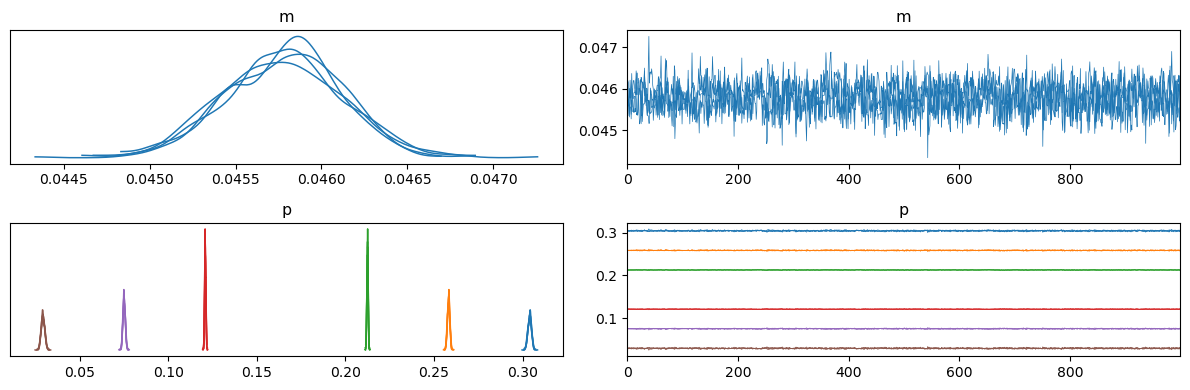

In [28]:
az.plot_trace(trace,
    # var_names=[],
    compact=True,
#    figsize=(10, 20),
    chain_prop=dict(linestyle='-'),
    trace_kwargs=dict(linestyle='-', linewidth=0.5, alpha=1),
             )
plt.tight_layout()

In [89]:
tons = np.array([
    [1, 0, 0, 0,  0,  0],
    [1, 0, 0, 0,  0,  0],
    [1, 0, 0, 0,  0,  0],
    [1, 0, 0, 0,  0,  0],
    [1, 0, 0, 0,  0,  0],
    [1, 0, 0, 0,  0,  0],
    [0, 1, 0, 0,  0,  0],
    [0, 1, 0, 0,  0,  0],
    [0, 1, 0, 0,  0,  0],
    [0, 1, 0, 0,  0,  0],
    [0, 1, 0, 0,  0,  0],    
    [0, 0, 1, 0,  0,  0],
    [0, 0, 1, 0,  0,  0],
    [0, 0, 1, 0,  0,  0],
    [0, 0, 1, 0,  0,  0],
    [0, 0, 0, 1,  0,  0],
    [0, 0, 0, 1,  0,  0],
    [0, 0, 0, 1,  0,  0],
    [0, 0, 0, 0,  1,  0],
    [0, 0, 0, 0,  1,  0],
    [0, 0, 0, 0,  0,  1]
])
tons = np.repeat(tons, 100, axis=0)
tons.shape

(2100, 6)

In [97]:
lst = np.arange(6,0,-1) / 12
lst

array([0.5       , 0.41666667, 0.33333333, 0.25      , 0.16666667,
       0.08333333])

In [87]:
lst = np.concatenate((np.arange(3,0,-1), np.arange(-1,-4,-1)))
lst = np.array(list(range(6))) / 10
lst

array([ 3,  2,  1, -1, -2, -3])

Sampling: [counts, m]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [counts]


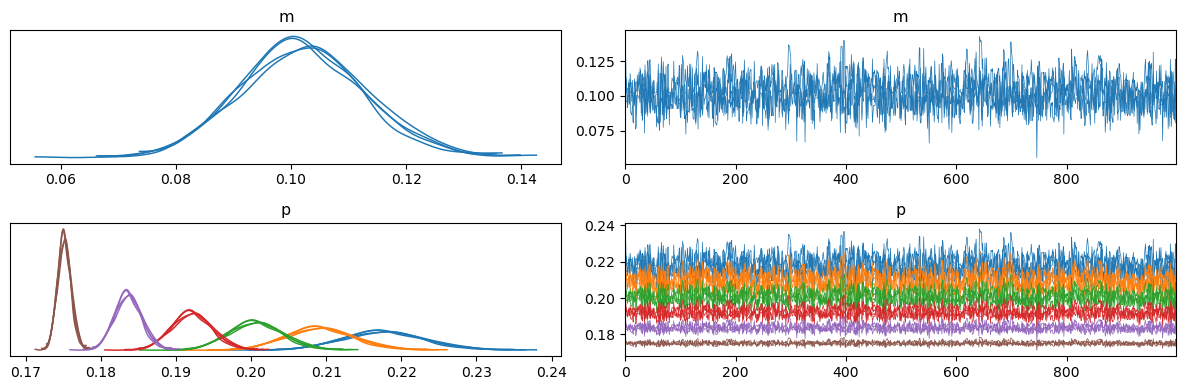

In [99]:
with pm.Model() as mod:

    # Prior distributions.
    m = pm.Uniform('m', lower=0, upper=0.15)
    # m = pm.Uniform('m', lower=0, upper=0.1)
    p = pm.Deterministic('p', 1/6 + lst*m)

    # SO INSTEAD OF THE UNIFORM I SHOULD HAVE A NORMAL PRIOR FOR SOME PARAMETER FOR 
    # THE PHASETYPE DISTRIBUTION, AND INSTEAD OF the determinisitic I should have 
    # a custom dist that returns the p vector, given the popgen parameter

    # or maybe I should use a derichelet prior to produce the p vector?...

    
    # Likelihood.
    counts_likelihood = pm.Bernoulli('counts', p=p, shape=(2100, 6), observed=tons)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    idata.extend(pm.sample_posterior_predictive(idata))


az.plot_trace(idata,
    # var_names=[],
    compact=True,
#    figsize=(10, 20),
    chain_prop=dict(linestyle='-'),
    trace_kwargs=dict(linestyle='-', linewidth=0.5, alpha=1),
             )
plt.tight_layout()

In [53]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [66]:
post_mean = idata.posterior.mean(dim=("chain", "draw"))

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# group_val = xr.DataArray(np.linspace(10000, 50000, 200), dims=["plot_dim"])
# posterior = idata.posterior

# slope = posterior["hyp_slope_inter"] + posterior["hyp_slope_slope"] * group_val
# ax1.plot(group_val, slope.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
# ax1.plot(group_val, post_mean["hyp_slope_inter"] + post_mean["hyp_slope_slope"] * group_val, c="C2")
# ax1.set_xlabel("group_val")
# ax1.set_ylabel("slope") 
# inter = posterior["hyp_inter_inter"] + posterior["hyp_slope_inter"] * group_val
# ax2.plot(group_val, inter.stack(sample=("chain", "draw")), c="C0", alpha=0.01)
# ax2.plot(group_val, post_mean["hyp_inter_inter"] + post_mean["hyp_slope_inter"] * group_val, c="C2")
# ax2.set_xlabel("group_val")
# ax2.set_ylabel("intercept")
# plt.tight_layout()

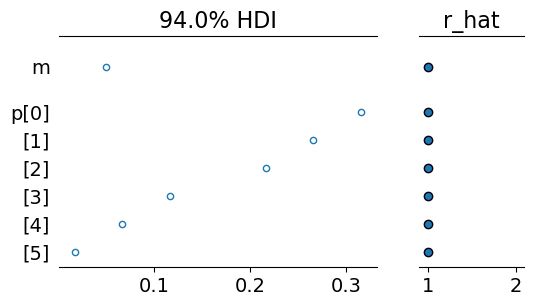

In [67]:
ax = pm.plot_forest(
    idata,
    var_names=["m", "p"],
    figsize=(6, 3),
    combined=True,
    r_hat=True,
    # backend_kwargs={'font' : {'family' : 'normal',
    #     'weight' : 'bold',
    #     'size'   : 22}},
    # labeller=az.labels.NoVarLabeller(),
)
#ax[0].set_yticks(fontsize=20)
#ax[0].set_ylabel("alpha")